# Example to compute and plot reduced electron distributions from FPI (based on Khotyaintsev et al., 2020, PRL)

author: Louis Richard\
email: louisr@irfu.se

In [1]:
# 3rd party imports
import matplotlib.pyplot as plt
import numpy as np

from pyrfu import mms, pyrf
from pyrfu.plot import plot_spectr, plot_line

mms.db_init("/Volumes/mms")

%matplotlib inline

Load IGRF coefficients ...


## Load data

### Define time interval and spacecraft index

In [2]:
tint = ["2015-12-02T01:14:55.500", "2015-12-02T01:14:56.600"]

tint_long = ["2015-12-02T01:14:45.500", "2015-12-02T01:15:02.500"]
mms_id = 4

### Get magnetic field in spacecraft coordinates

In [3]:
b_dmpa = mms.get_data("b_dmpa_fgm_brst_l2", tint_long, mms_id)

11-Apr-23 14:19:20: Loading mms4_fgm_b_dmpa_brst_l2...


### Get electric field in spacecraft coordinates and spacecraft potential

In [4]:
e_dsl = mms.get_data("e_dsl_edp_brst_l2", tint_long, mms_id)
scpot = mms.get_data("v_edp_brst_l2", tint_long, mms_id)

11-Apr-23 14:19:20: Loading mms4_edp_dce_dsl_brst_l2...
11-Apr-23 14:19:20: Loading mms4_edp_scpot_brst_l2...


### Get the electron velocity distribution skymap and the uncertainties ($\delta f / f = 1/\sqrt{n}$ with $n$ the number of counts)

In [5]:
vdf_e = mms.get_data("pde_fpi_brst_l2", tint_long, mms_id)
vdf_e_err = mms.get_data("pderre_fpi_brst_l2", tint_long, mms_id)

11-Apr-23 14:19:20: Loading mms4_des_dist_brst...
11-Apr-23 14:19:20: /opt/anaconda3/lib/python3.8/site-packages/pyrfu/mms/get_dist.py:64: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)

11-Apr-23 14:19:21: Loading mms4_des_disterr_brst...


### Ignore phase-space density for one count level (also makes function faster)

In [6]:
vdf_e.data.data[vdf_e.data.data < 1.1 * vdf_e_err.data.data] = 0.

### Define coordinates

In [7]:
x_hat = pyrf.resample(b_dmpa, vdf_e)
x_hat.data /= pyrf.norm(pyrf.resample(b_dmpa, vdf_e)).data[:, np.newaxis]
y_hat = pyrf.resample(pyrf.cross(e_dsl, b_dmpa), vdf_e)
y_hat.data /= pyrf.norm(y_hat).data[:, np.newaxis]
z_hat = pyrf.cross(x_hat, y_hat)

11-Apr-23 14:19:22: /opt/anaconda3/lib/python3.8/site-packages/pyrfu/pyrf/resample.py:133: UserWarning: Using averages in resample
  warnings.warn("Using averages in resample", UserWarning)

11-Apr-23 14:19:22: /opt/anaconda3/lib/python3.8/site-packages/pyrfu/pyrf/resample.py:133: UserWarning: Using averages in resample
  warnings.warn("Using averages in resample", UserWarning)



### Create transformation matrix

In [8]:
xyz = np.transpose(np.stack([x_hat.data, y_hat.data, z_hat.data]), [1, 2, 0])
xyz = pyrf.ts_tensor_xyz(vdf_e.time.data, xyz)

### Define velocity grid parallel to the magnetic field

In [9]:
vpara_lim = np.array([-10e3, 10e3], dtype=np.float64)
vg_para = np.linspace(vpara_lim[0], vpara_lim[1], 100)

### Reduce distribution along the magnetic field

In [10]:
f1dpara = mms.reduce(vdf_e, dim="1d", xyz=xyz, n_mc=200, vg=vg_para * 1e3, sc_pot=scpot, lower_e_lim=30.)
f1dpara = f1dpara.assign_coords(vx=f1dpara.vx.data / 1e3)

11-Apr-23 14:19:22: /opt/anaconda3/lib/python3.8/site-packages/pyrfu/pyrf/resample.py:133: UserWarning: Using averages in resample
  warnings.warn("Using averages in resample", UserWarning)

100%|██████████| 566/566 [00:34<00:00, 16.57it/s]


### Plot

(16771.05203125, 16771.05204398148)

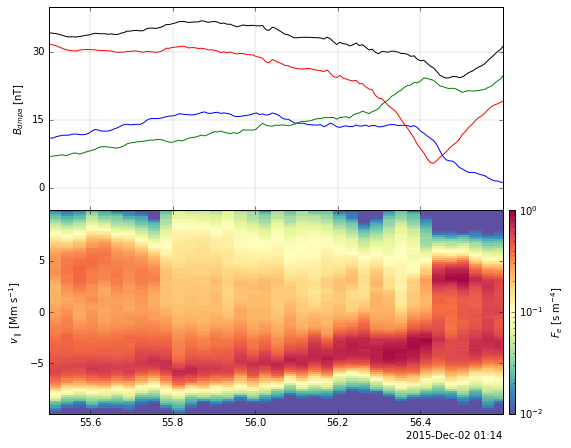

In [11]:
f, axs = plt.subplots(2, sharex="all", figsize=(9, 6.5))
f.subplots_adjust(hspace=0., left=.15, right=.85, bottom=.08, top=.95)
plot_line(axs[0], b_dmpa)
plot_line(axs[0], pyrf.norm(b_dmpa), color="k")
axs[0].set_ylim([-5, 40])
axs[0].set_ylabel("$B_{dmpa}~[\mathrm{nT}]$")

axs[1], cax1 = plot_spectr(axs[1], f1dpara, cscale="log", clim=[1e-2, 1e0], cmap="Spectral_r")
axs[1].set_ylim([-9.9, 9.9])
axs[1].set_ylabel("$v_\\parallel~[\\mathrm{Mm}~\\mathrm{s}^{-1}]$")
cax1.set_ylabel("$F_e~[\\mathrm{s}~\\mathrm{m}^{-4}]$")

axs[-1].set_xlim(pyrf.iso86012datetime64(np.array(tint)))

### 

## 2D projection of the ion velocity distribution functions

### Define times for 2D projection

In [12]:
t = ["2015-12-02T01:15:02.020000000", "2015-12-02T01:14:56.440", "2015-12-02T01:14:56.380", 
     "2015-12-02T01:14:56.290", "2015-12-02T01:14:55.810", "2015-12-02T01:14:55.600"]

### Reduce ion distributions in 2d plane $(B,E\times B)$

In [13]:
f2d = []

for t_ in t:
    t_ = pyrf.extend_tint([t_, t_], [-.06, .06])
    tmp = mms.reduce(pyrf.time_clip(vdf_e, t_), xyz=pyrf.time_clip(xyz, t_), dim="2d", base="cart", 
                     n_mc=200 * 5, vg=vg_para * 1e3)
    f2d.append(tmp.assign_coords(vx=tmp.vx.data / 1e3, vy=tmp.vy.data / 1e3))

100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


### Plot

Text(0.02, 0.5, '$v_{E\\times B}~[\\mathrm{Mm}~\\mathrm{s}^{-1}]$')

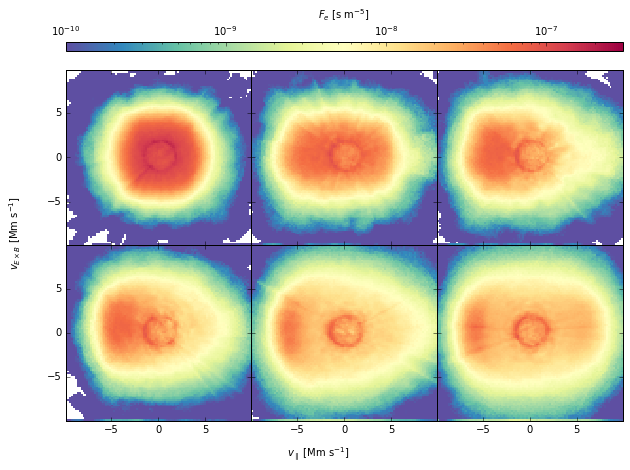

In [14]:
f, axs = plt.subplots(2, 3, sharex="all", sharey="all", figsize=(9, 6.5))
f.subplots_adjust(wspace=0, hspace=0, left=.11, right=.97, bottom=.1, top=.85)


axs[0, 0], cax0 = plot_spectr(axs[0, 0], f2d[0].mean(axis=0), cscale="log", clim=[1e-10, 3e-7], cmap="Spectral_r", colorbar="top")
axs[0, 0].set_xlim([-1e4, 1e4])
axs[0, 0].set_ylim([-1e4, 1e4])

for f_2d, ax in zip(f2d[1:], axs.flatten()[1:]):
    ax = plot_spectr(ax, f_2d.mean(axis=0), cscale="log", clim=[1e-10, 3e-7], cmap="Spectral_r", colorbar="none")
    ax.set_xlim([-9.9, 9.9])
    ax.set_ylim([-9.9, 9.9])

pos_axs02 = axs[0, 2].get_position()
pos_cax0 = cax0.get_position()
x0 = pos_cax0.x0
y0 = pos_cax0.y0 + 0.03
width = pos_axs02.x0 + pos_axs02.width - pos_cax0.x0
height = .02
cax0.set_position([x0, y0, width, height])    
cax0.set_xlabel("$F_e~[\\mathrm{s}~\\mathrm{m}^{-5}]$")

f.supxlabel("$v_{\\parallel}~[\\mathrm{Mm}~\\mathrm{s}^{-1}]$")
f.supylabel("$v_{E\\times B}~[\\mathrm{Mm}~\\mathrm{s}^{-1}]$")
